In [1]:
import pickle
import numpy as np
import scvelo as scv
import scanpy
import torch
import pandas as pd

from scipy.io import mmread
from veloproj import *

scv.settings.verbosity = 1

In [2]:
def filter_X(genes, X, kept_list):
    gene_dict = {gene:idx for idx, gene in enumerate(genes)}
    indices = [gene_dict[gene] for gene in kept_list]
    return X.tocsr()[:, indices]

def get_batch_info(postfix, ids, df):
    df.index = ids
    target_ids = [id for id in ids if id.endswith(postfix)]
    df = df.loc[target_ids]
    df.index = [id.split("_")[0] for id in df.index]
    return df

def load_adata():
    df_tsne_pca = pd.read_csv("/data/groups/yhhuang/veloData/intestine/atlas_tSNE_PCA_update.txt", delimiter="\t")
    df_meta = pd.read_csv("/data/groups/yhhuang/veloData/intestine/atlas_metadata.txt", delimiter="\t")
    df_meta1 = get_batch_info("M2", df_meta.NAME, df_meta)
    df_tsne1 = get_batch_info("M2", df_tsne_pca.NAME, df_tsne_pca)
    df_meta2 = get_batch_info("M1", df_meta.NAME, df_meta)
    df_tsne2 = get_batch_info("M1", df_tsne_pca.NAME, df_tsne_pca)
    counts1 = mmread("/data/groups/yhhuang/veloData/intestine/bams/batch1/GSM2839445_Atlas1_matrix.mtx").T
    barcodes1 = pd.read_csv("/data/groups/yhhuang/veloData/intestine/bams/batch1/GSM2839445_Atlas1_barcodes.tsv", header=None).values.flatten()
    barcodes1 = [ba[:-2] for ba in barcodes1]
    genes1 = pd.read_csv("/data/groups/yhhuang/veloData/intestine/bams/batch1/GSM2839445_Atlas1_genes.tsv", header=None).values.flatten()
    counts2 = mmread("/data/groups/yhhuang/veloData/intestine/bams/batch2/GSM2839446_Atlas2_matrix.mtx.gz").T
    barcodes2 = pd.read_csv("/data/groups/yhhuang/veloData/intestine/bams/batch2/GSM2839446_Atlas2_barcodes.tsv", header=None).values.flatten()
    barcodes2 = [ba[:-2] for ba in barcodes2]
    genes2 = pd.read_csv("/data/groups/yhhuang/veloData/intestine/bams/batch2/GSM2839446_Atlas2_genes.tsv", header=None).values.flatten()

    genes1 = list(map( lambda x:x.split("\t")[-1], genes1))
    genes2 = list(map( lambda x:x.split("\t")[-1], genes2))

    adata1 = scanpy.read_loom("/data/groups/yhhuang/veloData/intestine/bams/batch1/velocyto_res/SRR6254355_Atlas1_MUYSH.loom")
    adata2 = scanpy.read_loom("/data/groups/yhhuang/veloData/intestine/bams/batch2/velocyto_res/SRR6254356_Atlas2_NBFHR.loom")
    adata1.var_names_make_unique()
    adata2.var_names_make_unique()

    ovl_genes1 = np.sort(np.intersect1d(genes1, adata1.var_names))
    ovl_genes2 = np.sort(np.intersect1d(genes2, adata2.var_names))

    adata1.obs.index = [ba.split(":")[-1][:-1] for ba in adata1.obs_names]
    adata2.obs.index = [ba.split(":")[-1][:-1] for ba in adata2.obs_names]
    # adata1.obs.index = list(map(lambda x:x.split(":")[-1][:-1] + '-1', adata1.obs_names))
    adata1 = adata1[barcodes1, ovl_genes1]
    adata2 = adata2[barcodes2, ovl_genes2]
    # adata2.obs.index = list(map(lambda x:x.split(":")[-1][:-1] + '-1', adata2.obs_names))
    adata1.X = filter_X(genes1, counts1, ovl_genes1)
    adata2.X = filter_X(genes2, counts2, ovl_genes2)

    adata1 = adata1[df_meta1.index]
    adata1.obs['cluster'] = df_meta1.Cluster
    adata1.obsm['X_umap'] = df_tsne1[["X", "Y"]].values
    adata1.obsm['X_pca'] = df_tsne1[["PC1",	"PC2", "PC3", "PC4", "PC5"]].values

    adata2 = adata2[df_meta2.index]
    adata2.obs['cluster'] = df_meta2.Cluster
    adata2.obsm['X_umap'] = df_tsne2[["X", "Y"]].values
    adata2.obsm['X_pca'] = df_tsne2[["PC1",	"PC2", "PC3", "PC4", "PC5"]].values

    adata = scanpy.concat([adata1, adata2])
    adata.obs_names_make_unique()
    # adata, adata1, adata2
    return adata

In [3]:
adata = load_adata()
adata

AnnData object with n_obs × n_vars = 2635 × 25716
    obs: 'cluster'
    obsm: 'X_umap', 'X_pca'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [4]:
parser = get_parser()
args = parser.parse_args(args=['--lr', '1e-6', 
                               '--n-epochs', '20000', 
                               '--g-rep-dim', '100',
                               '--k-dim', '100',
                               '--model-name', 'intestinal_model.cpt',
                               '--exp-name', 'CohAE_intestinal',
                               '--device', 'cuda:1',
                               '--nb_g_src', "SU",
                               '--ld_nb_g_src', "SU",
                               '--gumbsoft_tau', '5',
                               '--n_raw_gene', '2000',
                               '--n_conn_nb', '30',
                               '--n_nb_newadata', '30',
                               '--aux_weight', '1',
                               '--fit_offset_train', 'false',
                               '--fit_offset_pred', 'true',
                               '--use_offset_pred', 'false',
                               '--gnn_layer', 'GAT',
                               '--vis-key', 'X_umap',
                               '--vis_type_col', 'cluster',
                               '--scv_n_jobs', '10',
                              ])
args                              

Namespace(adata=None, aux_weight=1.0, conv_thred=1e-06, data_dir=None, device='cuda:1', exp_name='CohAE_intestinal', fit_offset_pred=True, fit_offset_train=False, g_rep_dim=100, gnn_layer='GAT', gumbsoft_tau=5.0, h_dim=256, is_half=False, k_dim=100, ld_adata='projection.h5', ld_nb_g_src='SU', log_interval=100, lr=1e-06, lr_decay=0.9, mask_cluster_list=None, model_name='intestinal_model.cpt', n_conn_nb=30, n_epochs=20000, n_nb_newadata=30, n_raw_gene=2000, nb_g_src='SU', output='./', refit=True, scv_n_jobs=10, seed=42, sl1_beta=1.0, use_norm=False, use_offset_pred=False, use_x=False, v_rg_wt=0.0, vis_key='X_umap', vis_type_col='cluster', weight_decay=0.0, z_dim=100)

In [5]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [6]:
cluster_edges = [('Enterocyte.Immature.Distal', 'Enterocyte.Mature.Distal'),
                 ( 'Enterocyte.Immature.Proximal',  'Enterocyte.Mature.Proximal'),
                 ('Enterocyte.Progenitor.Early', 'Enterocyte.Progenitor'),
                 ('Enterocyte.Progenitor', 'Enterocyte.Progenitor.Late'),
                 ( 'TA.G1','TA.G2')
                ]

EXP_NAME = args.exp_name
exp_metrics = {}

In [7]:
def main_AE(args, adata):
    spliced = adata.layers['Ms']
    unspliced = adata.layers['Mu']
    tensor_s = torch.FloatTensor(spliced).to(device)
    tensor_u = torch.FloatTensor(unspliced).to(device)
    tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
    tensor_v = torch.FloatTensor(adata.layers['stc_velocity']).to(device)

    model = init_model(adata, args, device)

    inputs = [tensor_s, tensor_u]
    xyids = [0, 1]
    if args.use_x:
        inputs.append(tensor_x)

    model = fit_model(args, adata, model, inputs, tensor_v, xyids, device)
    return tensor_s, tensor_u, tensor_x  

In [8]:
scv.utils.show_proportions(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=args.n_raw_gene)
scv.pp.moments(adata)
print(adata)

Abundance of ['spliced', 'unspliced']: [0.81 0.19]
AnnData object with n_obs × n_vars = 2635 × 2000
    obs: 'cluster', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'neighbors'
    obsm: 'X_umap', 'X_pca'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'


  0%|          | 0/2635 [00:00<?, ?cells/s]

saving figure to file ./figures/scvelo_intestinal_stc.png


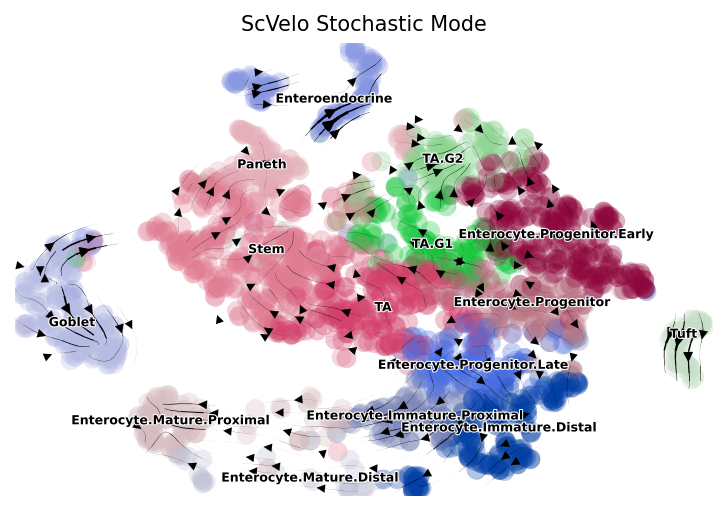

# Cross-Boundary Transition Score (A->B)
{('Enterocyte.Immature.Distal', 'Enterocyte.Mature.Distal'): 0.031179368, ('Enterocyte.Immature.Proximal', 'Enterocyte.Mature.Proximal'): 0.0525984, ('Enterocyte.Progenitor.Early', 'Enterocyte.Progenitor'): 0.091311075, ('Enterocyte.Progenitor', 'Enterocyte.Progenitor.Late'): 0.07387895, ('TA.G1', 'TA.G2'): 0.15202291}
Total Mean: 0.08019814640283585
# Cross-Boundary Velocity Coherence (A->B)
{('Enterocyte.Immature.Distal', 'Enterocyte.Mature.Distal'): 0.76249295, ('Enterocyte.Immature.Proximal', 'Enterocyte.Mature.Proximal'): 0.86926204, ('Enterocyte.Progenitor.Early', 'Enterocyte.Progenitor'): 0.5066435, ('Enterocyte.Progenitor', 'Enterocyte.Progenitor.Late'): 0.5217966, ('TA.G1', 'TA.G2'): 0.4630522}
Total Mean: 0.6246494054794312
# Cross-Boundary Direction Correctness (A->B)
{('Enterocyte.Immature.Distal', 'Enterocyte.Mature.Distal'): -0.13826199226456568, ('Enterocyte.Immature.Proximal', 'Enterocyte.Mature.Proximal'): 0.6926123881830025, ('

In [9]:
scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
scv.tl.velocity_graph(adata, vkey='stc_velocity', n_jobs=args.scv_n_jobs)
scv.tl.velocity_confidence(adata, vkey='stc_velocity')
scv.pl.velocity_embedding_stream(adata,  
                                vkey="stc_velocity", 
                                basis=args.vis_key, color=args.vis_type_col,
                                dpi=150, 
                                legend_fontsize=6,
                                save="intestinal_stc.png",
                                title='ScVelo Stochastic Mode')
exp_metrics["stc_mode"] = evaluate(adata, cluster_edges, args.vis_type_col, "stc_velocity")

Loss: (Total) 0.022229, (AE) 0.022186, (LR) 1.00 * 0.000043: 100%|██████████| 20000/20000 [15:53<00:00, 20.98it/s]


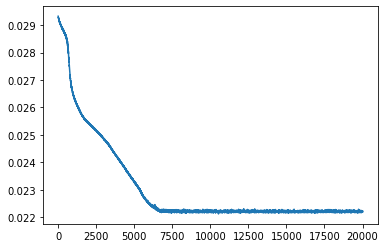

In [10]:
tensor_s, tensor_u, tensor_x = main_AE(args, adata)

or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.


  0%|          | 0/2635 [00:00<?, ?cells/s]

saving figure to file ./figures/scvelo_intestinal_pojection.png


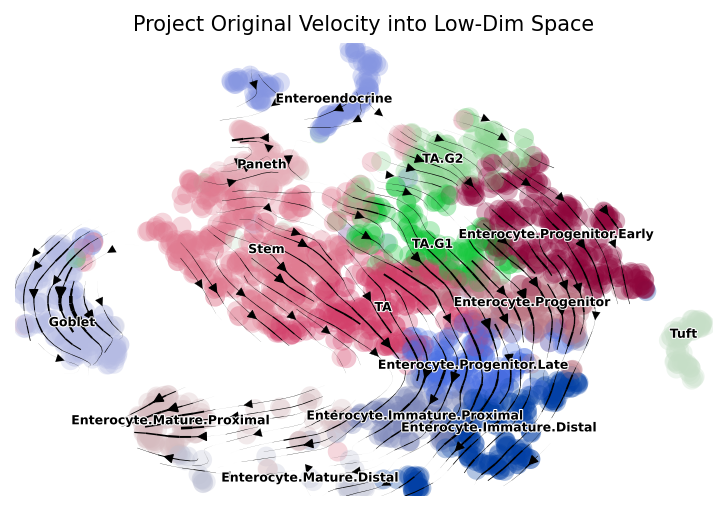

# Cross-Boundary Transition Score (A->B)
{('Enterocyte.Immature.Distal', 'Enterocyte.Mature.Distal'): 0.22286963, ('Enterocyte.Immature.Proximal', 'Enterocyte.Mature.Proximal'): 0.27855557, ('Enterocyte.Progenitor.Early', 'Enterocyte.Progenitor'): 0.14666209, ('Enterocyte.Progenitor', 'Enterocyte.Progenitor.Late'): 0.18244241, ('TA.G1', 'TA.G2'): 0.09670791}
Total Mean: 0.18544752895832062
# Cross-Boundary Velocity Coherence (A->B)
{('Enterocyte.Immature.Distal', 'Enterocyte.Mature.Distal'): 0.99994963, ('Enterocyte.Immature.Proximal', 'Enterocyte.Mature.Proximal'): 0.9998632, ('Enterocyte.Progenitor.Early', 'Enterocyte.Progenitor'): 0.9999226, ('Enterocyte.Progenitor', 'Enterocyte.Progenitor.Late'): 0.9999299, ('TA.G1', 'TA.G2'): 0.9999675}
Total Mean: 0.9999265670776367
# Cross-Boundary Direction Correctness (A->B)
{('Enterocyte.Immature.Distal', 'Enterocyte.Mature.Distal'): 0.6211145597495615, ('Enterocyte.Immature.Proximal', 'Enterocyte.Mature.Proximal'): 0.5561638676087085, ('Ente

In [11]:
def exp(adata, exp_metrics):
    model = init_model(adata, args, device)
    model.load_state_dict(torch.load(args.model_name))
    model = model.to(device)
    model.eval()
    with torch.no_grad():

        spliced = adata.layers['Ms']
        unspliced = adata.layers['Mu']
        tensor_s = torch.FloatTensor(spliced).to(device)
        tensor_u = torch.FloatTensor(unspliced).to(device)
        tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
        
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        v = estimate_ld_velocity(s, u, device=device, perc=[5, 95], 
                                 norm=args.use_norm, fit_offset=args.fit_offset_pred, 
                                 use_offset=args.use_offset_pred).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
    
    scv.pp.neighbors(adata)
    adata = new_adata(adata, x, s, u, v, g_basis=args.ld_nb_g_src, n_nb_newadata=args.n_nb_newadata)
    scv.pp.neighbors(adata)
    
    scv.tl.velocity_graph(adata, vkey='new_velocity', n_jobs=args.scv_n_jobs)
    scv.pl.velocity_embedding_stream(adata,
                                    vkey="new_velocity", basis=args.vis_key, color=[args.vis_type_col],
                                    title="Project Original Velocity into Low-Dim Space", smooth=0.5,
                                    dpi=150, legend_fontsize=6,
                                    save='intestinal_pojection.png')  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Cohort AutoEncoder'] = evaluate(adata, cluster_edges, args.vis_type_col, "new_velocity")
exp(adata, exp_metrics)

Abundance of ['spliced', 'unspliced']: [0.81 0.19]


  0%|          | 0/337 [00:00<?, ?gene/s]

  0%|          | 0/2635 [00:00<?, ?cells/s]

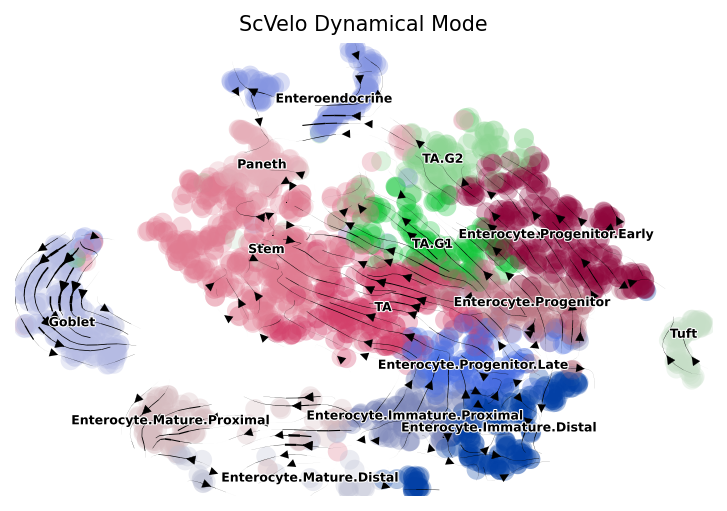

# Cross-Boundary Transition Score (A->B)
{('Enterocyte.Immature.Distal', 'Enterocyte.Mature.Distal'): 0.078314416, ('Enterocyte.Immature.Proximal', 'Enterocyte.Mature.Proximal'): 0.041748162, ('Enterocyte.Progenitor.Early', 'Enterocyte.Progenitor'): 0.07521783, ('Enterocyte.Progenitor', 'Enterocyte.Progenitor.Late'): 0.13093235, ('TA.G1', 'TA.G2'): 0.15974203}
Total Mean: 0.0971909612417221
# Cross-Boundary Velocity Coherence (A->B)
{('Enterocyte.Immature.Distal', 'Enterocyte.Mature.Distal'): 0.6643786283614782, ('Enterocyte.Immature.Proximal', 'Enterocyte.Mature.Proximal'): 0.5312244084159179, ('Enterocyte.Progenitor.Early', 'Enterocyte.Progenitor'): 0.6959214130440609, ('Enterocyte.Progenitor', 'Enterocyte.Progenitor.Late'): 0.6409357502481289, ('TA.G1', 'TA.G2'): 0.6581328023375916}
Total Mean: 0.6381186004814354
# Cross-Boundary Direction Correctness (A->B)
{('Enterocyte.Immature.Distal', 'Enterocyte.Mature.Distal'): -0.5495839743810196, ('Enterocyte.Immature.Proximal', 'Enterocyte

In [12]:
adata = load_adata()
scv.utils.show_proportions(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=args.n_raw_gene)
scv.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

scv.tl.recover_dynamics(adata, n_jobs=args.scv_n_jobs)
scv.tl.velocity(adata, vkey='dyn_velocity', mode="dynamical")

scv.tl.velocity_graph(adata, vkey='dyn_velocity', n_jobs=args.scv_n_jobs)
scv.tl.velocity_confidence(adata, vkey='dyn_velocity')
scv.pl.velocity_embedding_stream(adata,  
                                vkey="dyn_velocity", 
                                legend_fontsize=6,
                                basis=args.vis_key, 
                                color=[args.vis_type_col],
                                dpi=150, 
                                title='ScVelo Dynamical Mode')
exp_metrics["dyn_mode"] = evaluate(adata[:, adata.var.dyn_velocity_genes], cluster_edges, args.vis_type_col, "dyn_velocity")

In [13]:
with open("{}.pkl".format(EXP_NAME), 'wb') as out_file:
    pickle.dump(exp_metrics, out_file)